In [2]:
import pandas as pd
import numpy as np
import math
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

In [ ]:
data = pd.read_csv("processed_HRA_data.csv")

In [ ]:
data.head()

In [ ]:
data.info()

### Handling Date Time Conversion

In [ ]:
# Convert 'user_first_touch_timestamp' column to datetime format
data['user_first_touch_date_converted'] = pd.to_datetime(data['user_first_touch_timestamp'], format='%d-%m-%Y %H:%M')

# Extract date part only and assign it to 'user_first_touch_date_converted' column
data['user_first_touch_date_converted'] = data['user_first_touch_date_converted'].dt.date

# Create a new column for the time component
data['user_first_touch_time_converted'] = pd.to_datetime(data['user_first_touch_timestamp'], format='%d-%m-%Y %H:%M').dt.time

# Convert 'user_first_touch_date_converted' to the desired format
data['user_first_touch_date_converted'] = data['user_first_touch_date_converted'].apply(lambda x: x.strftime('%m-%d-%Y') if not pd.isnull(x) else '')


In [ ]:
# Convert 'user_first_touch_timestamp' column to datetime format
data['event_timestamp_date_converted'] = pd.to_datetime(data['event_timestamp'], format='%d-%m-%Y %H:%M')

# Extract date part only and assign it to 'user_first_touch_date_converted' column
data['event_timestamp_date_converted'] = data['event_timestamp_date_converted'].dt.date

# Create a new column for the time component
data['event_timestamp_time_converted'] = pd.to_datetime(data['event_timestamp'], format='%d-%m-%Y %H:%M').dt.time

In [ ]:
data.head()

In [ ]:
data.to_csv('Cleaned_Data.csv', index=False) 

In [9]:
Data = pd.read_csv("Cleaned_Data.csv")

In [10]:
Data.head()

,user_pseudo_id,hostname,page_location,event_date,user_first_touch_timestamp,event_timestamp,event_name,event_category,event_label,page_location_description,page_location_detail,page_location_version,Converted_event_names,Converted_event_category,user_first_touch_date_converted,user_first_touch_time_converted,event_timestamp_date_converted,event_timestamp_time_converted
0,1.032952e+09,humanatlas.io,https://humanatlas.io/,2-26-2024,10-01-2024 15:20,26-02-2024 12:20,session_start,NaN,NaN,Homepage/Portal,NaN,NaN,Session Start,NaN,01-10-2024,15:20:00,2-26-2024,12:20:00
1,1.032952e+09,humanatlas.io,https://humanatlas.io/,2-26-2024,10-01-2024 15:20,26-02-2024 12:20,page_view,NaN,NaN,Homepage/Portal,NaN,NaN,Page View,NaN,01-10-2024,15:20:00,2-26-2024,12:20:00
2,1.032952e+09,humanatlas.io,https://humanatlas.io/ccf-ontology,2-26-2024,10-01-2024 15:20,26-02-2024 12:20,page_view,NaN,NaN,Common Coordinate Framework Ontology,NaN,NaN,Page View,NaN,01-10-2024,15:20:00,2-26-2024,12:20:00
3,1.032952e+09,humanatlas.io,https://humanatlas.io/ccf-ontology,2-26-2024,10-01-2024 15:20,26-02-2024 12:20,scroll,NaN,NaN,Common Coordinate Framework Ontology,NaN,NaN,Scroll,NaN,01-10-2024,15:20:00,2-26-2024,12:20:00
4,1.032952e+09,humanatlas.io,https://humanatlas.io/,2-26-2024,10-01-2024 15:20,26-02-2024 12:20,page_view,NaN,NaN,Homepage/Portal,NaN,NaN,Page View,NaN,01-10-2024,15:20:00,2-26-2024,12:20:00


## Average pages per session


In [ ]:
# Filtering the DataFrame as needed (assuming 'filtered_hra' is a filtered version of 'df')
filtered_hra = Data[Data['event_name'].isin(['page_view', 'session_start'])]

# Grouping by 'hostname' to calculate average pages per session
average_pages_per_session = filtered_hra.groupby('hostname').apply(
    lambda x: pd.Series({
        'average_pages_per_session': x['event_name'].eq('page_view').sum() / x['event_name'].eq('session_start').sum(),
        'total_session_starts': x['event_name'].eq('session_start').sum()
    })
).reset_index()

# Calculating the overall average pages per session
total_sessions = average_pages_per_session['total_session_starts'].sum()
overall_average = (average_pages_per_session['average_pages_per_session'] * average_pages_per_session['total_session_starts']).sum() / total_sessions

overall_average_pages_per_session = pd.DataFrame({
    'average_pages_per_session': [overall_average],
    'total_session_starts': [total_sessions]
})

# Using openpyxl to handle Excel operations
wb = Workbook()
ws = wb.create_sheet(title="Avg Pages per Session")

# Write the data to the worksheet
for r in dataframe_to_rows(average_pages_per_session, index=False, header=True):
    ws.append(r)

# Save the workbook
wb.save('average_pages_per_session.xlsx')

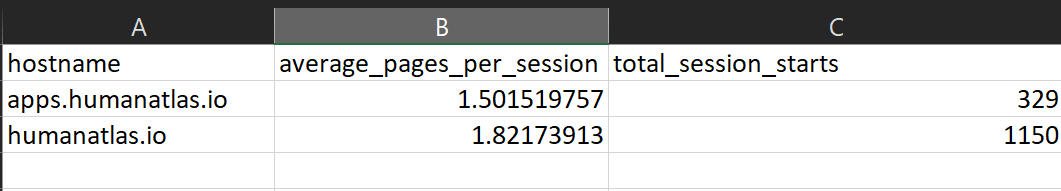

## Average Session Duration

In [12]:
# Filter out rows where event_name is 'first_visit'
filtered_data = Data[Data['event_name'] != 'first_visit']

# Sort the data by hostname, user_pseudo_id, event_date, and event_timestamp
sorted_data = Data.sort_values(by=['hostname', 'user_pseudo_id', 'event_date', 'event_timestamp'])

# Using ExcelWriter to write the sorted data into a new Excel sheet
with pd.ExcelWriter('sorted_data.xlsx', engine='openpyxl') as writer:  # Ensure you have openpyxl installed
    sorted_data.to_excel(writer, sheet_name='Sorted HRA', index=False)


In [13]:
# Remove duplicate rows based on specific columns
filtered_sorted_data = sorted_data.drop_duplicates(subset=['user_pseudo_id', 'hostname', 'page_location', 'event_timestamp'])

# Add a session index that increments with each 'session_start' event
filtered_sorted_data['session_index'] = (filtered_sorted_data.groupby(['user_pseudo_id', 'hostname'])['event_name']
                                         .transform(lambda x: (x == 'session_start').cumsum()))

# Convert event_timestamp to datetime format
filtered_sorted_data['event_timestamp_time_converted'] = pd.to_datetime(filtered_sorted_data['event_timestamp_time_converted'], errors='coerce')

# Drop rows with missing datetime values
filtered_sorted_data = filtered_sorted_data.dropna(subset=['event_timestamp_time_converted'])

# Calculate min and max timestamps per session and compute session durations
def calculate_session_duration(group):
    min_timestamp = group['event_timestamp_time_converted'].min()
    max_timestamp = group['event_timestamp_time_converted'].max()
    session_duration_seconds = (max_timestamp - min_timestamp).total_seconds()
    hours, remainder = divmod(session_duration_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    session_duration_hms = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"
    return pd.Series([min_timestamp, max_timestamp, session_duration_seconds, session_duration_hms],
                     index=['min_timestamp', 'max_timestamp', 'session_duration', 'session_duration_hms'])

time_per_session = filtered_sorted_data.groupby(['user_pseudo_id', 'hostname', 'session_index', 'event_date']).apply(calculate_session_duration)

# Using ExcelWriter to write the session duration data into a new Excel sheet
with pd.ExcelWriter('sorted_data.xlsx', engine='openpyxl', mode='a') as writer:
    time_per_session.to_excel(writer, sheet_name='Individual Session Details', index=True)


C:\Users\AATMAN VASOYA\AppData\Local\Temp\ipykernel_45880\2965673281.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sorted_data['session_index'] = (filtered_sorted_data.groupby(['user_pseudo_id', 'hostname'])['event_name']
C:\Users\AATMAN VASOYA\AppData\Local\Temp\ipykernel_45880\2965673281.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_sorted_data['event_timestamp_time_converted'] = pd.to_datetime(filtered_sorted_data['event_timestamp_time_converted'], errors='coerce')
C:\Users\AATMAN VASOYA\AppData\Local\Temp\ipykernel_45880\2965673281.py:14: SettingWithCopyWarning: 
A value is

In [17]:
# Group by hostname to calculate average session duration for each hostname
average_session_duration = time_per_session.groupby('hostname')['session_duration'].mean().reset_index()

# Convert average duration from seconds to HH:MM:SS format
average_session_duration['average_duration_hms'] = average_session_duration['session_duration'].apply(
    lambda x: f"{int(x // 3600):02}:{int((x % 3600) // 60):02}:{int(x % 60):02}"
)

# Calculate total average session duration across all hostnames
total_average_duration = time_per_session['session_duration'].mean()

# Convert total average duration to HH:MM:SS format and add it as a new row
total_average_duration_hms = f"{int(total_average_duration // 3600):02}:{int((total_average_duration % 3600) // 60):02}:{int(total_average_duration % 60):02}"
total_average_row = pd.DataFrame({'hostname': ['Total'],
                                  'session_duration': [total_average_duration],
                                  'average_duration_hms': [total_average_duration_hms]})

# Concatenate the total average row to the DataFrame
average_session_duration = pd.concat([average_session_duration, total_average_row], ignore_index=True)

# Using ExcelWriter to append this data to the existing Excel file
with pd.ExcelWriter('sorted_data.xlsx', engine='openpyxl', mode='a') as writer:
    average_session_duration.to_excel(writer, sheet_name='Average Session Durations', index=False)


### Bounce Rate

In [19]:
# Count zero duration sessions for each domain
zero_duration_sessions_per_domain = time_per_session[time_per_session['session_duration'] < 1].groupby('hostname').size().reset_index(name='zero_duration')

# Count number of session starts for each domain
session_starts_per_domain = time_per_session.groupby('hostname').size().reset_index(name='session_starts')

# Merge the data frames for zero duration sessions and session starts by hostname
domain_rows = pd.merge(zero_duration_sessions_per_domain, session_starts_per_domain, on='hostname', how='outer').fillna(0)

# Calculate the ratio for each domain
domain_rows['ratio'] = domain_rows['zero_duration'] / domain_rows['session_starts']

# Calculate the total values
total_values = {
    'hostname': 'Total',
    'zero_duration': domain_rows['zero_duration'].sum(),
    'session_starts': domain_rows['session_starts'].sum()
}
total_values['ratio'] = total_values['zero_duration'] / total_values['session_starts']

# Append total values to the domain rows
total_values_df = pd.DataFrame([total_values])
result = pd.concat([domain_rows, total_values_df], ignore_index=True)

# Using ExcelWriter to append this data to the existing Excel file
with pd.ExcelWriter('sorted_data.xlsx', engine='openpyxl', mode='a') as writer:
    result.to_excel(writer, sheet_name='Bounce Rate', index=False)
